## Associative Recall Task

This experimental notebook is inspired by the _associative recall_ task as defined by [Collier and Beel (2018)](https://arxiv.org/pdf/1807.08518.pdf) based on the original _Neural Turing Machines_ paper of [Graves, Wayne, and Danihelka (2014)](https://arxiv.org/abs/1410.5401).

In particular, the input time series for this task consist of up to 18 random 6-bit vectors, subdivided into blocks of three, followed by a sequence end token (in this case a one on an extra input channel) and then followed by one of the blocks of 3 from the previous input. The number of blocks is sampled uniformly at random in the interval $[2, 6]$. After the input sequence has ended, the neural net should produce the _next_ item in the input sequence after the presented item. This task requires both a notion of order in memory and a notion of content-based addressing to find the memory location, which makes it hard even for memory models.

In [1]:
import random
import numpy as np

task = 'associative_recall'

# set up experimental hyperparameters
n = 6
block_length = 3
max_blocks = 6

# the number of training time series in each repeat
N = 90
# the number of test time series in each repeat
N_test = 10

# define the input generating function
def generate_seq():
    # start by sampling the number of input blocks
    T = random.randrange(2, max_blocks+1)
    # initialize the input sequence
    X = np.zeros(((block_length)*(T+2)+1, n+1))
    # fill the input sequence with random bits
    X[:T*block_length, :n] = np.round(np.random.rand(T*block_length, n))
    # add the sequence end token
    X[T*block_length, n] = 1.
    # enumerate the blocks in the state sequence
    Q = np.zeros((block_length)*(T+2)+1)
    Q[(2*block_length-1):T*block_length:block_length] = np.arange(1, T)
    # then select a random item
    i = random.randrange(T-1)
    # and copy it once again to the input
    lo = T*block_length+1
    hi = (T+1)*block_length+1
    X[lo:hi,:] = X[(i*block_length):((i+1)*block_length), :]
    # set the associated state
    Q[hi-1] = i+1
    # copy the input sequence to the output
    Y = np.zeros(((block_length)*(T+2)+1, n))
    Y[block_length:, :] = X[:-block_length, :n]
    # finally, put the _next_  item in the input sequence to the output
    lo = hi
    i += 1
    Y[lo-1:, :] = X[(i*block_length)-1:((i+1)*block_length), :n]
    # return
    return X, Q, Y

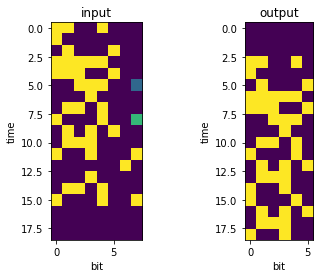

In [2]:
import matplotlib.pyplot as plt
# show an example data point
X, Q, Y = generate_seq()
plt.subplot(1, 2, 1)
plt.imshow(np.concatenate((X, Q[:, None] / np.max(Q)), 1))
plt.title('input')
plt.xlabel('bit')
plt.ylabel('time')
plt.subplot(1, 2, 2)
plt.imshow(Y)
plt.title('output')
plt.xlabel('bit')
plt.ylabel('time')
plt.show()

## Hyperparameter Optimization

In [3]:
# set the hyper-parameter ranges for all models
models = ['ESN', 'CRJ', 'LMU', 'RMM_ESN', 'RMM_CRJ', 'RMM_LMU']
# all models get the same number of neurons
m = 256
hyperparam_ranges = {
    'ESN' : {
        'radius' : [0.5, 0.7, 0.9],
        'sparsity' : [0.1, 0.2, 0.5],
        'regul' : [1E-7, 1E-5, 1E-3]
    },
    'CRJ' : {
        'v' : [0.1, 0.3, 0.5],
        'w_c' : [0.1, 0.7, 0.9],
        'w_j' : [0.1, 0.2, 0.4],
        'l' : [4, 8, 16],
        'regul' : [1E-7, 1E-5, 1E-3]
    },
    'LMU' : {
        'regul' : [1E-7, 1E-5, 1E-3]
    },
    'RMM_ESN' : {
        'radius' : [0.5, 0.7, 0.9],
        'sparsity' : [0.1, 0.2, 0.5],
        'regul' : [1E-7, 1E-5, 1E-3],
        'C' : [1., 100., 10000.]
    },
    'RMM_CRJ' : {
        'v' : [0.1, 0.3, 0.5],
        'w_c' : [0.1, 0.7, 0.9],
        'w_j' : [0.1, 0.2, 0.4],
        'l' : [4, 8, 16],
        'regul' : [1E-7, 1E-5, 1E-3],
        'C' : [1., 100., 10000.]
    },
    'RMM_LMU' : {
        'regul' : [1E-7, 1E-5, 1E-3],
        'C' : [1., 100., 10000.]
    }
}

import rmm2.esn as esn
import rmm2.crj as crj
import rmm2.lmu as lmu
import rmm2.rmm_assoc as rmm_assoc

# set up a function to initialize an instance for each model
def setup_model(model, hyperparams):
    # first, set up the correct reservoir and nonlinearity
    if model.endswith('ESN'):
        U, W = esn.initialize_reservoir(m, n+1, radius = hyperparams['radius'], sparsity = hyperparams['sparsity'])
        nonlin = np.tanh
    elif model.endswith('CRJ'):
        U = crj.setup_input_weight_matrix(n+1, m, v = hyperparams['v'])
        W = crj.setup_reservoir_matrix(m, w_c = hyperparams['w_c'], w_j = hyperparams['w_j'], l = hyperparams['l'])
        nonlin = np.tanh
    elif model.endswith('LMU'):
        degree = int(m/(n+1))-1
        U, W = lmu.initialize_reservoir(n+1, degree, block_length * max_blocks)
        nonlin = lambda x : x
    else:
        raise ValueError('Unknown model: %s' % model)
    # then, set up the model
    if not model.startswith('RMM_'):
        net = esn.ESN(U, W, regul = hyperparams['regul'], input_normalization = False, nonlin = nonlin)
    else:
        e_n = np.zeros(n+1)
        e_n[-1] = -1.
        init_state = np.dot(U, e_n)
        net = rmm_assoc.RMM(U, W, regul = hyperparams['regul'], input_normalization = False, nonlin = nonlin, C = hyperparams['C'], init_state = init_state, horizon = block_length * 2, svm_kernel = 'rbf')
    return net

In [4]:
# perform a hyperoptimization where we test R random hyperparameter
# settings for each model and perform num_repeats repeats to obtain
# statistics. The hyperparameters with the best mean performance across
# repeats will be selected

hyper_R = 20
hyper_num_repeats = 3

# try to load the selected hyperparameters from file
import json
import os
import random

hyperparam_path = '%s_hyperparams.json' % task
if os.path.isfile(hyperparam_path):
    with open(hyperparam_path, 'r') as hyperparam_file:
        hyperparams = json.load(hyperparam_file)
else:
    # generate random parameter combination for all models
    hyperparams = {}
    for model in models:
        hyperparams[model] = []
        for r in range(hyper_R):
            params_r = {}
            hyperparams[model].append(params_r)
            # sample a novel random combination of hyper parameters
            # for the current model
            for key in hyperparam_ranges[model]:
                param_range = hyperparam_ranges[model][key]
                value = param_range[random.randrange(len(param_range))]
                params_r[key] = value
            # set up an extra key for the errors
            params_r['errors'] = []

    for repeat in range(hyper_num_repeats):
        print('--- repeat %d of %d ---' % (repeat+1, hyper_num_repeats))
        # sample training data
        Xs = []
        Qs = []
        Ys = []
        for i in range(N):
            X, Q, Y = generate_seq()
            Xs.append(X)
            Qs.append(Q)
            Ys.append(Y)
        # sample test data
        Xs_test = []
        Ys_test = []
        for i in range(N_test):
            X, _, Y = generate_seq()
            Xs_test.append(X)
            Ys_test.append(Y)
        # now iterate over all models
        for model in models:
            print('-- model: %s --' % model)
            # and iterate over all parameter combinations for this model
            for params_r in hyperparams[model]:
                # set up a model instance
                net = setup_model(model, params_r)
                # fit the model to the data
                if model.startswith('RMM_'):
                    net.fit(Xs, Qs, Ys)
                else:
                    net.fit(Xs, Ys)
                # measure the RMSE on the test data
                mse = 0.
                for i in range(N_test):
                    Ypred = net.predict(Xs_test[i])
                    mse   += np.mean((Ypred - Ys_test[i]) ** 2)
                rmse = np.sqrt(mse / N_test)
                params_r['errors'].append(rmse)
                print(rmse)
    # write the results to a JSON file
    with open(hyperparam_path, 'w') as hyperparam_file:
        json.dump(hyperparams, hyperparam_file)

# select best hyperparameters for each model
hyperparams_opt = {}
for model in models:
    min_err = np.inf
    for params_r in hyperparams[model]:
        if np.mean(params_r['errors']) < min_err:
            min_err = np.mean(params_r['errors'])
            hyperparams_opt[model] = params_r
    print('\nSelected the following hyper-parameters for %s' % model)
    for key in hyperparams_opt[model]:
        print('%s: %s' % (key, str(hyperparams_opt[model][key])))

--- repeat 1 of 3 ---
-- model: ESN --
0.4233251345957374
0.45494600962516646
0.4710945893665399
0.44837410537523636
0.47156801579987684
0.4251991757783975
0.44643944351575493
0.4171552171748618
0.42543660308171216
0.41407109796424185
0.47591054830077684
0.407153344420798
0.4481002858914139
0.4121031253771774
0.4454890300160218
0.4534102855630012
0.4341098148343308
0.420150267834668
0.4736864552163087
0.4506481530121787
-- model: CRJ --
0.3697711059494154
0.3576299301881461
0.40120471878394237
0.4097765927442759
0.39887353671251036
0.3135591884109437
0.4543057172493596
0.3160382803939562
0.4498034075508895
0.4227631678062468
0.33265311927797725
0.38243914267852924
0.4017748488975718
0.433566823336413
0.41188016986605497
0.37573734963699607
0.3236644400085186
0.3984297969869741
0.4021303171124942
0.35891383797944065
-- model: LMU --
0.31860867456187675
0.31860867456187675
0.31860661235721927
0.31860661235721927
0.31860661235721927
0.31860661235721927
0.31860867456187675
0.31860867456187

## Actual Experiment

In [5]:
# set up the number of repeats for the actual experiment
R = 20

# perform the actual experiment in a crossvalidation
errors   = np.zeros((len(models), R))
runtimes = np.zeros((len(models), R))

import time

for r in range(R):
    print('--- repeat %d of %d ---' % (r+1, R))
    # sample training data
    Xs = []
    Qs = []
    Ys = []
    for i in range(N):
        X, Q, Y = generate_seq()
        Xs.append(X)
        Qs.append(Q)
        Ys.append(Y)
    # sample test data
    Xs_test = []
    Ys_test = []
    for i in range(N_test):
        X, _, Y = generate_seq()
        Xs_test.append(X)
        Ys_test.append(Y)
    # now iterate over all models
    for model_idx in range(len(models)):
        model = models[model_idx]
        # print('-- model: %s --' % model)
        # set up the model with the best selected hyperparameters
        start_time = time.time()
        net = setup_model(model, hyperparams_opt[model])
        # fit the model to the data
        if model.startswith('RMM_'):
            net.fit(Xs, Qs, Ys)
        else:
            net.fit(Xs, Ys)
        # measure the RMSE on the test data
        mse = 0.
        for i in range(N_test):
            Ypred = net.predict(Xs_test[i])
            mse   += np.mean((Ypred - Ys_test[i]) ** 2)
        rmse = np.sqrt(mse / N_test)
        runtimes[model_idx, r] = time.time() - start_time
        errors[model_idx, r] = rmse

--- repeat 1 of 20 ---
--- repeat 2 of 20 ---
--- repeat 3 of 20 ---
--- repeat 4 of 20 ---
--- repeat 5 of 20 ---
--- repeat 6 of 20 ---
--- repeat 7 of 20 ---
--- repeat 8 of 20 ---
--- repeat 9 of 20 ---
--- repeat 10 of 20 ---
--- repeat 11 of 20 ---
--- repeat 12 of 20 ---
--- repeat 13 of 20 ---
--- repeat 14 of 20 ---
--- repeat 15 of 20 ---
--- repeat 16 of 20 ---
--- repeat 17 of 20 ---
--- repeat 18 of 20 ---
--- repeat 19 of 20 ---
--- repeat 20 of 20 ---


In [6]:
for model_idx in range(len(models)):
    print('%s: %g +- %g (took %g seconds)' % (models[model_idx], np.mean(errors[model_idx, :]), np.std(errors[model_idx, :]), np.mean(runtimes[model_idx, :])))

ESN: 0.415371 +- 0.00820307 (took 0.103717 seconds)
CRJ: 0.310774 +- 0.00827017 (took 0.0332035 seconds)
LMU: 0.310171 +- 0.008047 (took 0.0482084 seconds)
RMM_ESN: 0.430216 +- 0.0181119 (took 1.39287 seconds)
RMM_CRJ: 0.202406 +- 0.0524104 (took 1.7004 seconds)
RMM_LMU: 0.100029 +- 0.0798568 (took 1.3706 seconds)


In [7]:
# store results
np.savetxt('%s_errors.csv' % task, errors.T, delimiter='\t', header='\t'.join(models), comments='')
np.savetxt('%s_runtimes.csv' % task, runtimes.T, delimiter='\t', header='\t'.join(models), comments='')

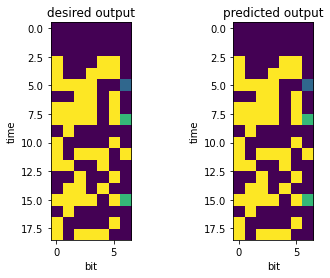

In [8]:
# show an example output and compare it to the actual output
X, Q, Y = generate_seq()
Ypred, Qpred = net.predict(X, True)

plt.subplot(1, 2, 1)
plt.imshow(np.concatenate((Y, Q[:, None] / np.max(Q)), 1))
plt.title('desired output')
plt.xlabel('bit')
plt.ylabel('time')
plt.subplot(1, 2, 2)
plt.imshow(np.concatenate((Ypred, Qpred[:, None] / np.max(Qpred)), 1))
plt.title('predicted output')
plt.xlabel('bit')
plt.ylabel('time')
plt.show()
